<a href="https://colab.research.google.com/github/deysohom99/Nuclei-detection-in-microscopy-images/blob/master/Nuclei_detection_in_microscopy_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [0]:
import os
import cv2
import math
import shutil
import numpy as np
import matplotlib.pyplot as plt

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [0]:
%%capture

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c data-science-bowl-2018

!unzip stage1_train.zip -d train_data

os.remove('stage1_train.zip')
os.remove('stage1_test.zip')
os.remove('stage2_test_final.zip')
os.remove('stage1_sample_submission.csv.zip')
os.remove('stage2_sample_submission_final.csv.zip')
os.remove('stage1_solution.csv.zip')
os.remove('stage1_train_labels.csv.zip')
os.remove('kaggle.json')

In [0]:
if os.path.exists('data'):
  shutil.rmtree('data')
os.mkdir('data')
os.mkdir('data/images')
os.mkdir('data/masks')

for c, i in enumerate(os.listdir('train_data')):
  img_path = 'train_data/'+i+'/images/'+i+'.png'
  img = cv2.imread(img_path, -1)
  cv2.imwrite('data/images/'+str(c)+'.png', img)

  msk_comb = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
  masks = os.listdir('train_data/'+i+'/masks')
  for j in masks:
    msk_path = 'train_data/'+i+'/masks/'+j
    msk = cv2.imread(msk_path, -1)
    msk_comb+=msk
  cv2.imwrite('data/masks/'+str(c)+'.png', msk_comb)

print('Process complete!')

Process complete!


In [0]:
img_files = [os.path.join('data/images', i) for i in os.listdir('data/images')]
msk_files = [os.path.join('data/masks', i) for i in os.listdir('data/masks')]

train_img_files = img_files[:500]
train_msk_files = msk_files[:500]

valid_img_files = img_files[500:]
valid_msk_files = msk_files[500:]

print('Number of training images:', len(train_img_files))
print('Number of validation images:', len(valid_img_files))

Number of training images: 500
Number of validation images: 170


In [0]:
class Generator(Sequence):

  def __init__(self, x_set, y_set, batch_size=10):
      self.x = x_set
      self.y = y_set
      self.batch_size = batch_size

  def __len__(self):
      return math.ceil(len(self.x) / self.batch_size)

  def __getitem__(self, idx):
      batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
      batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

      batch_x = np.array([cv2.resize(cv2.imread(file_name), (256, 256)) for file_name in batch_x])
      batch_y = np.array([cv2.resize(cv2.imread(file_name, -1), (256, 256)) for file_name in batch_y])

      batch_y = np.array([np.expand_dims(file_name, -1) for file_name in batch_y])

      return batch_x/255, batch_y/255

In [0]:
train_generator = Generator(train_img_files, train_msk_files)
valid_generator = Generator(valid_img_files, valid_msk_files)

In [0]:
for i, j in train_generator:
  print(i.shape)
  print(j.shape)
  break

(10, 256, 256, 3)
(10, 256, 256, 1)


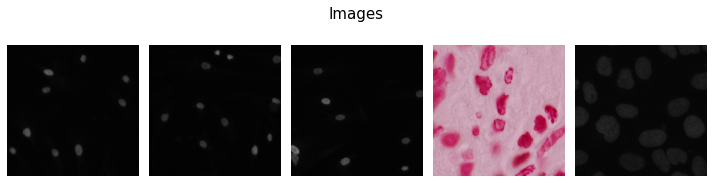

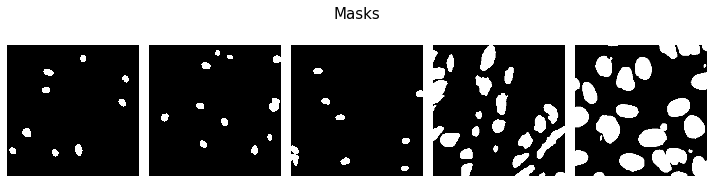

In [0]:
fig, axes = plt.subplots(1, 5, figsize=(10,3))
fig.suptitle('Images', fontsize=15)
axes = axes.flatten()
for img, ax in zip(i[:7], axes[:7]):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 5, figsize=(10,3))
fig.suptitle('Masks', fontsize=15)
axes = axes.flatten()
for img, ax in zip(j[:7], axes[:7]):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()

In [0]:
def calculate_iou(y_true, y_pred):
  intersection = np.sum(y_true * y_pred) +1
  union = np.sum(y_true) + np.sum(y_pred) - intersection + 1
  iou = intersection/union
  return iou

def IoU(y_true, y_pred): 
    iou = tf.py_function(calculate_iou, [y_true, y_pred], tf.float32)
    return iou

In [0]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
def UNet():

  inputs = Input((256, 256, 3))

  c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (inputs)
  c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
  p1 = MaxPooling2D((2, 2)) (c1)

  c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
  c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
  p2 = MaxPooling2D((2, 2)) (c2)

  c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
  c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
  p3 = MaxPooling2D((2, 2)) (c3)

  c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
  c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
  p4 = MaxPooling2D((2, 2)) (c4)

  c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
  c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

  u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
  c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

  u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
  c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

  u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
  c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

  u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = concatenate([u9, c1])
  c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
  c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

  outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

  model = Model(inputs=[inputs], outputs=[outputs])

  return model

In [0]:
K.clear_session()
model = UNet()

In [0]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[IoU, 'accuracy'])

In [0]:
earlystopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=10, 
    verbose=1, 
    restore_best_weights=True)

reducelr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3, 
    verbose=1,  
    min_delta=0.0001 )

callbacks = [earlystopping, reducelr]

In [0]:
history = model.fit(
    train_generator, 
    steps_per_epoch=50,
    epochs=200,
    validation_data = valid_generator,    
    validation_steps = 17,
    callbacks=callbacks
    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 50 steps, validate for 17 steps
Epoch 1/200
50/50 [==============================] - 29s 583ms/step - loss: 1.2037 - IoU: 0.1669 - accuracy: 0.8450 - val_loss: 0.7269 - val_IoU: 0.3249 - val_accuracy: 0.8913
Epoch 2/200
50/50 [==============================] - 29s 572ms/step - loss: 1.5053 - IoU: 0.4267 - accuracy: 0.8947 - val_loss: 0.8090 - val_IoU: 0.2820 - val_accuracy: 0.8915
Epoch 3/200
50/50 [==============================] - 29s 587ms/step - loss: 0.4702 - IoU: 0.5518 - accuracy: 0.9301 - val_loss: 0.3367 - val_IoU: 0.6582 - val_accuracy: 0.9503
Epoch 4/200
50/50 [==============================] - 30s 593ms/step - loss: 0.3230 - IoU: 0.6868 - accuracy: 0.9486 - val_loss: 0.2512 - val_IoU: 0.7418 - val_accuracy: 0.9621
Epoch 5/200
50/50 [==============================] - 29s 589ms/step - loss: 0.2346 - IoU: 0.7652 - accuracy: 0.9604 - val_loss: 0.2157 - val_IoU: 0.7711 - val_accuracy: 0.9658
Epoch 6/200
50/50 [=========